In [18]:
# fit a straight line with outlyers
# Hogg

In [64]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy.stats import laplace, norm
from numpy import log, exp, pi as π, sqrt, abs, sum, inf, full
from numba import njit

In [2]:
# Generate noisy data with outliers
np.random.seed(42)

N = 100
noise = np.random.normal(0, 1, size=N)

m_t = 2.5
b_t = 1.0

x_data = np.linspace(0, 10, N)
y_data = m_t * x_data + b_t + noise

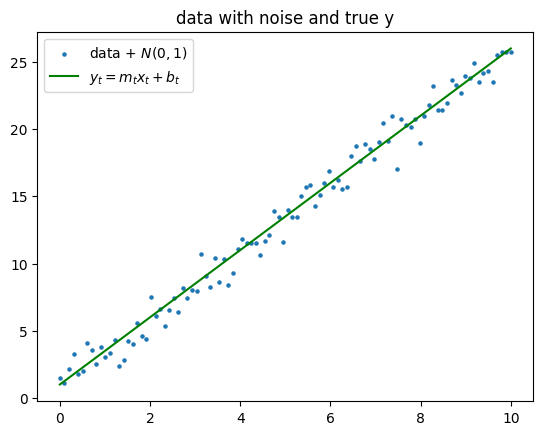

In [3]:
fig, ax = plt.subplots(1, 1)

ax.set(title="data with noise and true y")
ax.scatter(x_data, y_data, label="data + $N(0,1)$", s=5)
ax.plot(x_data, m_t*x_data + b_t, label=r"$y_t = m_t x_t + b_t$", c="g")

ax.legend()

In [4]:
# Add outliers
outliers_x = np.array([2, 5, 8])
outliers_y = np.array([20, 15, 30])
x_data_out = np.concatenate([x_data, outliers_x])
y_data_out = np.concatenate([y_data, outliers_y])

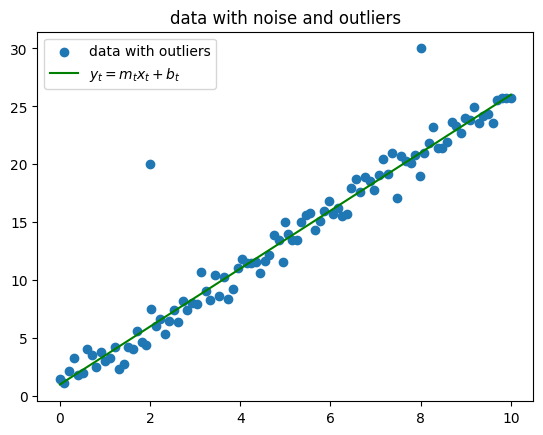

In [5]:
fig, ax = plt.subplots(1,1)
ax.set(title="data with noise and outliers")

ax.scatter(x_data_out, y_data_out, label="data with outliers")
ax.plot(x_data, m_t*x_data + b_t, label=r"$y_t = m_t x_t + b_t$", c="g")

ax.legend()

In [46]:
@njit
def norm_pdf(x, μ, σ):
    a = 1 / (sqrt(2 * π) * σ)
    return a * exp(-((x - μ) ** 2) / (2 * σ**2))


@njit
def laplace_pdf(x, μ, b):
    a = 0.5 / b
    return a * exp(-abs(x - μ) / b)


In [56]:
@njit
def likelihood(m, b, x, y, y_sigma=1.0, out_sigma=5.0, p_out=0.1):
    """Calculate the likelihood assuming a mixture of normal (inliers) and Laplace (outliers)."""
    y_model = m * x + b

    # Gaussian likelihood for y
    inlier_likelihood = norm_pdf(y, μ=y_model, σ=y_sigma)

    # Laplace likelihood for outliers (or we could use a t-distribution)
    outlier_likelihood = laplace_pdf(y, μ=y_model, b=out_sigma)

    # Mixture model: p_outlier is the probability of a point being an outlier
    return sum(log((1 - p_out) * inlier_likelihood + p_out * outlier_likelihood))


In [57]:
@njit
def prior(m, b):
    """uniform prior"""
    if -10 < m < 10 and -10 < b < 10:
        return 0  # log(1) = 0
    else:
        return -inf  # log(0) is -infinity


In [58]:
@njit
def posterior(m, b, x, y, y_sigma=1.0, out_sigma=5.0, p_out=0.1):
    """Posterior is proportional to likelihood * prior."""
    return prior(m, b) + likelihood(m, b, x, y, y_sigma, out_sigma, p_out)


In [73]:
@njit
def MCMC(posterior, initial_params, x, y, steps=100_000, proposal_width=0.5):
    m_current, b_current = initial_params
    posterior_current = posterior(m_current, b_current, x, y)

    samples = full((steps, 2), np.nan)

    for i in range(steps):
        # Propose new parameters
        m_proposal = np.random.normal(m_current, proposal_width)
        b_proposal = np.random.normal(b_current, proposal_width)

        # Calculate posterior for proposed parameters
        posterior_proposal = posterior(m_proposal, b_proposal, x, y)

        # Acceptance probability
        acceptance_prob = np.exp(posterior_proposal - posterior_current)

        # Accept or reject the proposal
        if np.random.rand() < acceptance_prob:
            m_current, b_current = m_proposal, b_proposal
            posterior_current = posterior_proposal

        # Store samples
        samples[i, :] = [m_current, b_current]

    return samples


In [75]:
# Run Metropolis-Hastings
initial_params = [0.0, 0.0]  # Initial guess for slope and intercept
samples = MCMC(posterior, initial_params, x_data_out, y_data_out)

# Plot the results
m_samples = samples[:, 0]
b_samples = samples[:, 1]

# 35 seconds... for 100k

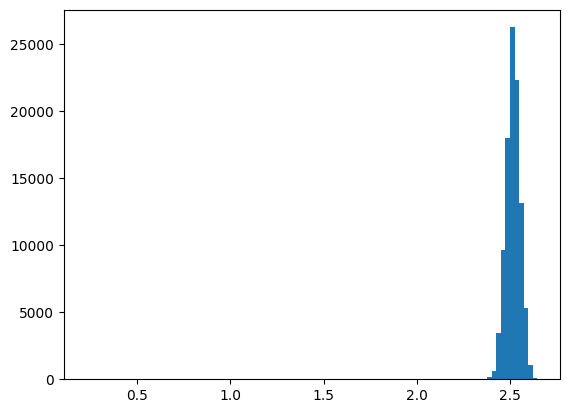

In [80]:
plt.hist(m_samples, 100);

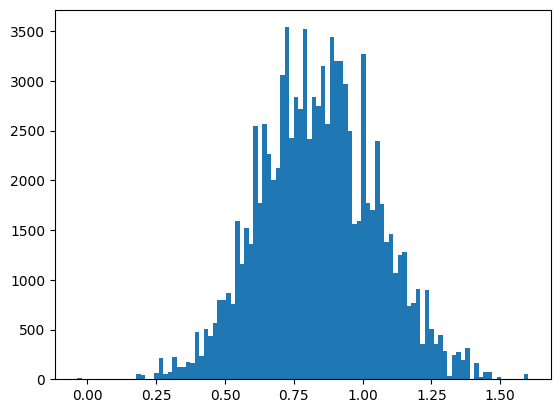

In [79]:
plt.hist(b_samples, 100);

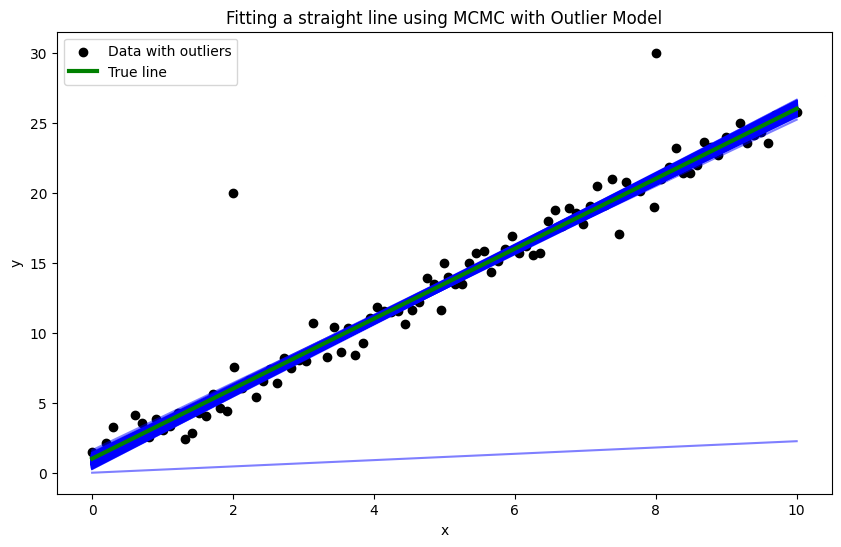

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set(
    title="Fitting a straight line using MCMC with Outlier Model",
    xlabel="x",
    ylabel="y",
)

# sampled lines
for i in range(0, len(samples), 100):
    ax.plot(x_data, m_samples[i] * x_data + b_samples[i], color="blue", alpha=0.5)

ax.scatter(x_data_out, y_data_out, label="Data with outliers", color="black")
ax.plot(x_data, m_t * x_data + b_t, label="True line", color="green", linewidth=3)


ax.legend()
